In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from utils import display

2024-03-15 21:55:11.900453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 21:55:11.900475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 21:55:11.901125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 0. Parameters

In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

# 1. Prepare the data

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

2024-03-15 21:55:13.981584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 21:55:13.991143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 21:55:14.003274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

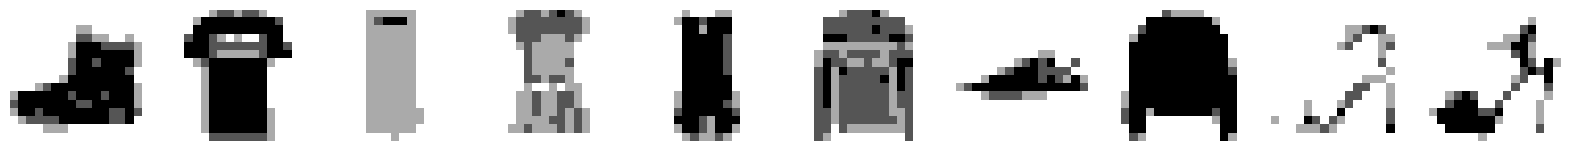

In [6]:
# Show some items of clothing from the training set
display(input_data)

# 2. Build the PixelCNN

In [7]:
# The first layer is the PixelCNN layer. This layer simply builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

# 3. Train the PixelCNN

In [10]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                            :, row, col, :
                            ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

In [12]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/150


2024-03-15 21:55:19.318927: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-15 21:55:20.838441: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-15 21:55:20.905040: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-15 21:55:21.471929: I external/local_xla/xla/service/service.cc:168] XLA service 0x7667d5a25c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 21:55:21.471948: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-15 21:55:21.475162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710550521.538244  471124 device_compiler.

469/469 [==============================] - 9s 12ms/step - loss: 0.4903
Epoch 2/150
469/469 [==============================] - 5s 10ms/step - loss: 0.4011
Epoch 3/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3865
Epoch 4/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3802
Epoch 5/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3762
Epoch 6/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3722
Epoch 7/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3695
Epoch 8/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3668
Epoch 9/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3645
Epoch 10/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3624
Epoch 11/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3604
Epoch 12/150
469/469 [==============================] - 5s 10ms/step - loss: 0.3581
Epoch 13/150


# 4. Generate images

In [13]:
generated_images = img_generator_callback.generate(temperature=1.0)

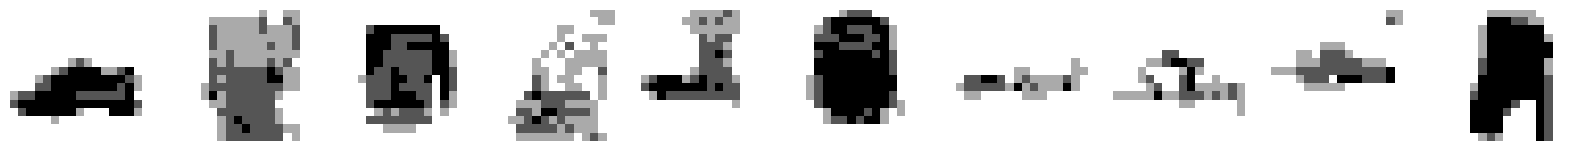

In [14]:
display(generated_images)